## importings 

In [290]:
import pandas as pd
import numpy as np

## Chose a ticker

In [291]:
ticker="AMZN"

## Stocks Data

In [292]:
# get the stock data
from google.cloud import storage
def get_stock_data_from_gcp(nrows=10000, local=False, optimize=False, ticker=None, **kwargs):
    """method to get the training data (or a portion of it) from google cloud bucket"""
    # Add Client() here
    client = storage.Client()
    if local:
        path = "data/data_data_10Mill.csv"
    else:
        path = "gs://stock-news-pred-bucket/stock_prices"
    df_stocks = pd.read_csv(path, sep="\t")#add nrows after if you want to select a specific number of row
    df_stocks.rename(columns={"Unnamed: 0":"date"}, inplace=True)
    df = df_stocks.sort_values(["date"], ascending=True)
    
    if ticker:
        df = df_stocks[["date", ticker]]
        df["date"] = pd.to_datetime(df['date'], infer_datetime_format=True)
        
    return df


In [293]:
#df_stocks = get_stock_data_from_gcp()

In [294]:
#df_stocks

In [295]:
df_stocks = get_stock_data_from_gcp(ticker=ticker)

/tmp/ipykernel_3498/1200910319.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = pd.to_datetime(df['date'], infer_datetime_format=True)


In [296]:
df_stocks

,date,AMZN
0,2021-11-22,3572.57
1,2021-11-19,3676.57
2,2021-11-18,3696.06
3,2021-11-17,3549.00
4,2021-11-16,3540.70
...,...,...
5547,1999-11-05,64.94
5548,1999-11-04,63.06
5549,1999-11-03,65.81
5550,1999-11-02,66.44


## Get the sentiment

In [297]:
# get the data from GCP
from google.cloud import storage
def get_sentiment_news_data_from_gcp(nrows=10000, local=False, optimize=False, ticker=None, **kwargs):
    """method to get the training data (or a portion of it) from google cloud bucket"""
    # Add Client() here
    client = storage.Client()
    if local:
        path = "data/data_data_10Mill.csv"
    else:
        path = "gs://stock-news-pred-bucket/Stocks_news_final_to_use.csv"
    sentiment = pd.read_csv(path)#add nrows after if you want to select a specific number of row
    sentiment = sentiment[['date', 'ticker', 'class_label']]
    sentiment["date"] = pd.to_datetime(sentiment["date"] , infer_datetime_format=True)
    sentiment.set_index(["date"], inplace=True)
    if ticker:
        sentiment_ticker = sentiment[sentiment['ticker'] == ticker]
        sentiment_ticker.drop(columns=['ticker'], inplace=True)
        return sentiment_ticker
    else:
        return sentiment

In [298]:
sentiment = get_sentiment_news_data_from_gcp(ticker=ticker)

/home/frcloers/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [308]:
sentiment = get_sentiment_news_data_from_gcp()

In [314]:
sentiment.ticker.unique()

array(['AAPL', 'GOOGL', 'MSFT'], dtype=object)

## Get Twitter Data

In [300]:
from google.cloud import storage
def get_twitter_stocks_sentiment_from_gcp(nrows=10000, local=False, optimize=False, ticker=None, **kwargs):
    """method to get the training data (or a portion of it) from google cloud bucket"""
    # Add Client() here
    client = storage.Client()
    if local:
        path = "data/data_data_10Mill.csv"
    else:
        path = "gs://stock-news-pred-bucket/Amazon1 twitter_stocks_sentiment.csv"
    
    if ticker=="AMZN":
        path = "gs://stock-news-pred-bucket/Amazon1 twitter_stocks_sentiment.csv"
    if ticker=="GOOGL":
        path = "gs://stock-news-pred-bucket/Google1 twitter_stocks_sentiment.csv"
    if ticker=="MSFT":
        path = "gs://stock-news-pred-bucket/Microsoft1 twitter_stocks_sentiment.csv"
    if ticker=="NFLX":
        path="gs://stock-news-pred-bucket/Netflix1 twitter_stocks_sentiment.csv"
        
    df = pd.read_csv(path, index_col= False)#add nrows after if you want to select a specific number of row
    df.drop(columns=["Unnamed: 0"], inplace=True)
    df.rename(columns={"class_label": "twitter_label"}, inplace=True)
    df["date"] = pd.to_datetime(df["date"] , infer_datetime_format=True)

    return df

In [301]:
df_twitter = get_twitter_stocks_sentiment_from_gcp(ticker=ticker)
df_twitter

,date,twitter_label
0,2020-11-26,0.352941
1,2020-11-27,0.666667
2,2020-11-28,0.428571
3,2020-11-29,0.142857
4,2020-11-30,0.666667
...,...,...
360,2021-11-21,0.600000
361,2021-11-22,0.463415
362,2021-11-23,0.311475
363,2021-11-24,0.459459


## Merging Datasets

In [302]:
def merge_data(df_stocks, df_news, df_twitter):
    df = pd.merge(df_stocks, df_news, on='date', how='outer')
    df_twitter_merge = pd.merge(df, df_twitter, on='date', how='outer')
    df_twitter_merge.rename(columns={"class_label": "news_label"}, inplace= True)
    df_twitter_merge.sort_values(["date"], inplace=True)
    mask = df_twitter_merge["news_label"].notnull()==True
    new_df = df_twitter_merge[mask]
    new_df.iloc[:,1].interpolate(method= "linear", inplace= True)
    #min_date = new_df["date"].min()
    #new_df = df.loc[min_date:,:]
    new_df.fillna(value=-1, inplace=True)
    
    return new_df

In [303]:
df = merge_data(df_stocks, sentiment, df_twitter)

/home/frcloers/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [306]:
df

,date,AMZN,news_label,twitter_label


In [305]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# INSTANTIATE THE SCALER
scaler = MinMaxScaler()

# FIT IT ONLY ON AMZN
scaler.fit(df[[ticker]])

# LET'S CREATE A COPY OF MERGED_DF
data_scaled = df.copy()


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.

In [ ]:
# AND TRANSFORM ONLY THE AMZN COLUMN
data_scaled[ticker] = scaler.transform(data_scaled[[ticker]])

# NOW LOOK AT DATA_SCALED
data_scaled.tail(20)

In [ ]:
data_scaled.to_csv(f"scaled_for_{ticker}")

## prepare the LSTM Model

In [208]:
# SETTING THE DATE AS INDEX
data_scaled.set_index(["date"], inplace= True)

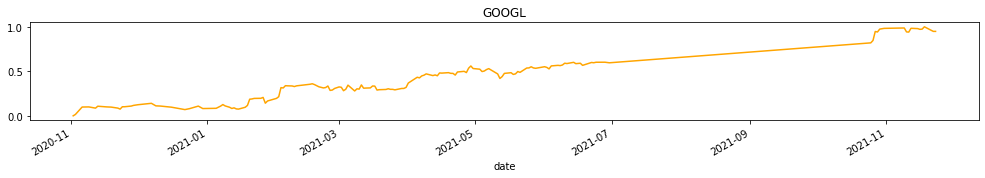

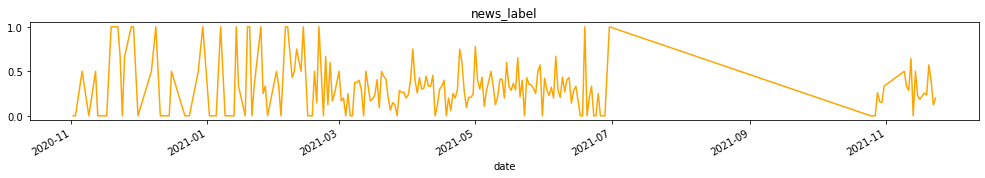

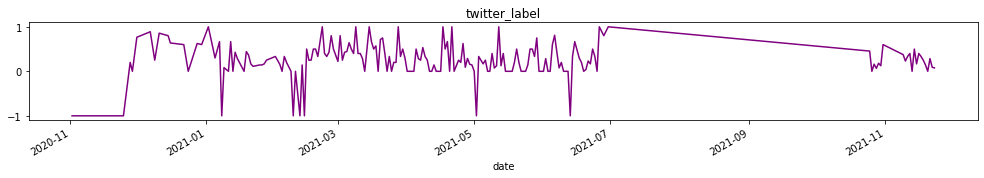

In [209]:
import matplotlib.pyplot as plt
%matplotlib inline

for column in data_scaled.columns:
    if column == ticker: color = "orange"
    if column == "class_label": color = "blue" 
    if column == "twitter_label": color = "purple" 
    data_scaled[column].plot(figsize=(17, 2), color=color)
    plt.title(column)
    plt.show()

In [210]:
data_scaled = data_scaled.drop_duplicates()

## Functions for the input shape of the model

In [211]:
import numpy as np

def subsample_sequence(df, length, HORIZON=0):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random
    """
    last_possible = df.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length+HORIZON]
    # X_sample = df_sample[random_start: random_start+length]
    # y_sample = df_sample[random_start + length:]
    return df_sample

In [212]:
def split_subsample_sequence(df, length, ticker):
    '''Create one single random (X,y) pair'''

    df_subsample = subsample_sequence(df, length)
    y_sample = df_subsample.iloc[length -1][ticker] # -1 means the future window
    
    X_sample = df_subsample[0:length -1]# -1 means the future window
    X_sample = X_sample.values

    return np.array(X_sample), np.array(y_sample)

In [213]:
def compute_means(X, df_mean):
    # Compute means of X
    means = X.mean()
    
    # Case if ALL values of at least one feature of X are NaN, then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)
        
    return means

def split_subsample_sequence(df, length, ticker, df_mean=None):
    '''Return one single random sample (X_sample, y_sample) containing one sequence each of length `length`'''
    # Trick to save time during potential recursive calls
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    
    y_sample = df_subsample.iloc[length-1][ticker]
    # Case y_sample is NaN: redraw !
    if y_sample != y_sample: # A value is not equal to itself only for NaN
            X_sample, y_sample = split_subsample_sequence(df, length, df_mean) # Recursive call !!!
            return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:length-1]
    # Case X_sample has some NaNs
    if X_sample.isna().sum().sum() !=0:
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        X_sample = X_sample.values
        
    return np.array(X_sample), np.array(y_sample)

In [214]:
def get_X_y(df, n_sequences, length, ticker): #length = 30, n_sequence = 12, df(12month)
    '''Return a list of samples (X, y)'''
    
    X, y = [], []

    for i in range(n_sequences):
        (xi, yi) = split_subsample_sequence(df, length, ticker)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)

    return X, y

## Train test split

In [215]:
# len of train dataset should be 80%
len_ = int(0.8*data_scaled.shape[0])
df_train = data_scaled[:len_]
df_test = data_scaled[len_:]
print(df_train.shape)
print(df_test.shape)

(165, 3)
(42, 3)


### Check the data 

In [216]:
df_train.head()

,GOOGL,news_label,twitter_label
date,,,
2020-11-02,0.000000,0.0,-1.0
2020-11-03,0.015549,0.0,-1.0
2020-11-06,0.098663,0.5,-1.0
2020-11-09,0.099894,0.0,-1.0
2020-11-12,0.086342,0.5,-1.0


In [217]:
X_train, y_train = get_X_y(df_train, 200, 30, ticker) # 200 sequences of a length of 30 days
X_test, y_test = get_X_y(df_test, 100, 30, ticker) # 200 sequences of a length of 30 days

In [218]:
X_train.shape, y_train.shape

((200, 29, 3), (200,))

In [219]:
X_test.shape, y_test.shape

((100, 29, 3), (100,))

## Predict a baseline

In [220]:
# We here decide to predict the mean of the train set y_train
y_pred = np.mean(y_train)
bench_res = np.mean(np.abs(y_pred - y_test)/y_test)*100

print(f'Benchmark MAPE on the test set : {bench_res:.0f} %')

Benchmark MAPE on the test set : 60 %


In [221]:
# Or (better) we predict the last pollution value!
y_pred_baseline = X_test[:,-1,0]
bench_res = np.mean(np.abs(y_pred_baseline - y_test)/y_test)*100
print(f'Benchmark MAPE on the test set : {bench_res:.0f} %')

Benchmark MAPE on the test set : 1 %


## Model

### imports for the model

In [222]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

### Model Init

In [223]:
def init_model_2():
    metric = metrics.MAPE
    opt = optimizers.RMSprop(learning_rate=0.005)
    
    model = models.Sequential()
    
    model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(10, activation='tanh'))
    
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer=opt, 
                  metrics=[metric])
    
    return model

In [224]:
model_2 = init_model_2()

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_2 = model_2.fit(X_train, y_train,
            validation_split=0.3,
            epochs=5, 
            batch_size=32,
            callbacks=[es], verbose=1)

Epoch 1/5
5/5 [==============================] - 17s 1s/step - loss: 0.0686 - mean_absolute_percentage_error: 56.3807 - val_loss: 0.0140 - val_mean_absolute_percentage_error: 33.1528
Epoch 2/5
5/5 [==============================] - 1s 231ms/step - loss: 0.0069 - mean_absolute_percentage_error: 20.7165 - val_loss: 0.0148 - val_mean_absolute_percentage_error: 44.0862
Epoch 3/5
5/5 [==============================] - 1s 246ms/step - loss: 0.0102 - mean_absolute_percentage_error: 24.6425 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 23.7537
Epoch 4/5
5/5 [==============================] - 1s 228ms/step - loss: 0.0047 - mean_absolute_percentage_error: 15.9672 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 30.2069
Epoch 5/5
5/5 [==============================] - 1s 222ms/step - loss: 0.0066 - mean_absolute_percentage_error: 20.6781 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 20.7534


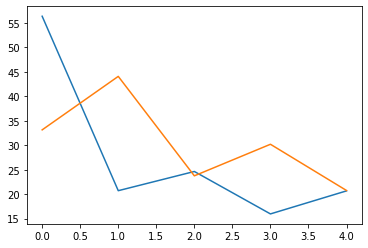

In [225]:
import matplotlib.pyplot as plt
plt.plot(history_2.history['mean_absolute_percentage_error'])
plt.plot(history_2.history['val_mean_absolute_percentage_error'])

In [226]:
res = model_2.evaluate(X_test, y_test, verbose=1)

print(f'MAPE on the test set : {res[1]:.0f} %')

4/4 [==============================] - 0s 57ms/step - loss: 0.1730 - mean_absolute_percentage_error: 42.6347
MAPE on the test set : 43 %


In [227]:
predictions_2 = model_2.predict(X_test)
predictions_2.shape

(100, 1)

In [228]:
unscaled_predictions_2 = scaler.inverse_transform(predictions_2)
unscaled_predictions_2[0:10] # showing 10 predictions in the test set out of 100 

array([[2405.3926],
       [2408.403 ],
       [2402.0325],
       [2363.678 ],
       [2363.678 ],
       [2410.6902],
       [2395.609 ],
       [2387.4148],
       [2410.6902],
       [2408.403 ]], dtype=float32)

In [229]:
error = y_test.reshape(-1,1)-unscaled_predictions_2

In [230]:
#adapt on lenth of df
X, y = get_X_y(data_scaled, len(df), 30, ticker)
X.shape, y.shape

((207, 29, 3), (207,))

In [231]:
predictions_X = model_2.predict(X)
predictions_X[:10]

array([[0.53871393],
       [0.30996037],
       [0.5481729 ],
       [0.2311261 ],
       [0.29874006],
       [0.35387695],
       [0.17766719],
       [0.16961706],
       [0.31253448],
       [0.49774703]], dtype=float32)

In [232]:
unscaled_predictions_X = scaler.inverse_transform(predictions_X)
unscaled_predictions_X[:10]

array([[2363.678 ],
       [2049.725 ],
       [2376.66  ],
       [1941.5289],
       [2034.3258],
       [2109.9985],
       [1868.1593],
       [1857.111 ],
       [2053.2578],
       [2307.453 ]], dtype=float32)

In [233]:

df_true_pred = df[["date", ticker]]
df_true_pred["predictions"]=unscaled_predictions_X
df_true_pred["ticker"] = ticker

/tmp/ipykernel_3498/2637398465.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_true_pred["predictions"]=unscaled_predictions_X


In [234]:
df_true_pred.head()

,date,GOOGL,predictions,ticker
266,2020-11-02,1624.32,2363.677979,GOOGL
265,2020-11-03,1645.66,2049.725098,GOOGL
262,2020-11-06,1759.73,2376.659912,GOOGL
261,2020-11-09,1761.42,1941.528931,GOOGL
258,2020-11-12,1742.82,2034.325806,GOOGL


In [235]:
df_true_pred.to_csv(f"LSTM_3features_{ticker}")